In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [2]:
# Load data (adjust the column names accordingly)
data = pd.read_excel('data_tm.xlsx')
data.rename(columns={'comment': 'Comment','Label (Ridho)': 'Label'}, inplace=True)
data

,no,Comment,Label
0,1,Alhamdulillah akhrinyaa kurikulum merdeka bany...,Kontra
1,2,Zonasi bikin ribet,Kontra
2,4,Kalau bisa sekolah SMA<br>Juga kabupaten <br>...,Kontra
3,5,Syukurlah...,Pro
4,6,"Kurikulum merdeka , pebisnis aplikasi dan LKS ...",Kontra
...,...,...,...
933,1382,Salam Merdeka Belajar... manfaatkan segala pot...,Pro
934,1383,Saya salut dengan program pak Nadiem yg satu i...,Pro
935,1384,"Wah....oke juga programnya nih, mengakomodir y...",Pro
936,1385,terimakasih kampus merdeka. program program ny...,Pro


In [3]:
data['Comment'].describe()



count        938
unique       927
top       Mantap
freq           4
Name: Comment, dtype: object

In [4]:
data['word_count'] = data['Comment'].apply(lambda x: len(x.split()))
data['word_count'].describe()

count    938.000000
mean      24.961620
std       32.211823
min        1.000000
25%        8.000000
50%       16.000000
75%       29.000000
max      457.000000
Name: word_count, dtype: float64

### Preprocessing

In [64]:
# Initialize stemmer for Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [65]:
# Load stopwords for Bahasa Indonesia (ensure NLTK stopwords are installed)
try:
    stop_words = set(stopwords.words('indonesian'))
except:
    import nltk
    nltk.download('stopwords')
    stop_words = set(stopwords.words('indonesian'))

def preprocess_text(text):
    """Clean and preprocess text."""
    # Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Apply stemming
    text = ' '.join([stemmer.stem(word) for word in words])
    return text


In [66]:
# Apply preprocessing to the comments
data['Cleaned_Comment'] = data['Comment'].apply(preprocess_text)

In [70]:
data

,no,Comment,Label,word_count,Cleaned_Comment
0,1,Alhamdulillah akhrinyaa kurikulum merdeka bany...,Kontra,21,alhamdulillah akhrinyaa kurikulum merdeka bany...
1,2,Zonasi bikin ribet,Kontra,3,zonasi bikin ribet
2,4,Kalau bisa sekolah SMA<br>Juga kabupaten <br>...,Kontra,7,sekolah sma kabupaten propinsi
3,5,Syukurlah...,Pro,1,syukur
4,6,"Kurikulum merdeka , pebisnis aplikasi dan LKS ...",Kontra,31,kurikulum merdeka bisnis aplikasi lks yg merde...
...,...,...,...,...,...
933,1382,Salam Merdeka Belajar... manfaatkan segala pot...,Pro,32,salam merdeka ajar manfaat potensi makna kelas...
934,1383,Saya salut dengan program pak Nadiem yg satu i...,Pro,63,salut program nadiem yg sy jg daftar program g...
935,1384,"Wah....oke juga programnya nih, mengakomodir y...",Pro,21,wahoke program nih mengakomodir alam praktis n...
936,1385,terimakasih kampus merdeka. program program ny...,Pro,13,terimakasih kampus merdeka program program nya...


### Exploratory Data Analysis

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [72]:
# 1. Shape of the data
print("Shape of the dataset:", data.shape)

Shape of the dataset: (938, 5)


In [73]:
# 2. Distribution of labels
# Distribusi label dihitung untuk mengetahui proporsi data 'Pro' dan 'Kontra'. Pastikan kolom label benar-benar bersih dan konsisten.
label_distribution = data['Label'].value_counts()
print("Label Distribution:\n", label_distribution)

Label Distribution:
 Label
Kontra    547
Pro       391
Name: count, dtype: int64


karna jumlah data imbalance dan dikhawatirkan akan terjadi overfitting maka kita akan melakukan cuting pada data yang memiliki jumlah kata dibawah 10

In [74]:
valid_kontra = data[(data['Label'] == 'Kontra') & (data['Cleaned_Comment'].apply(len) > 10)]
label_pro = data[data['Label'] == 'Pro']

In [75]:
# Mengurangi jumlah data 'Kontra' agar seimbang dengan 'Pro'
label_kontra_downsampled = resample(valid_kontra,
                                    replace=False,
                                    n_samples=len(label_pro),
                                    random_state=42)

In [76]:
# Menggabungkan dataset yang telah diseimbangkan
balanced_data = pd.concat([label_pro, label_kontra_downsampled])

# Mengacak dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [77]:
# Periksa distribusi baru
print("Distribusi Label Setelah Penyeimbangan:\n", balanced_data['Label'].value_counts())

Distribusi Label Setelah Penyeimbangan:
 Label
Kontra    391
Pro       391
Name: count, dtype: int64


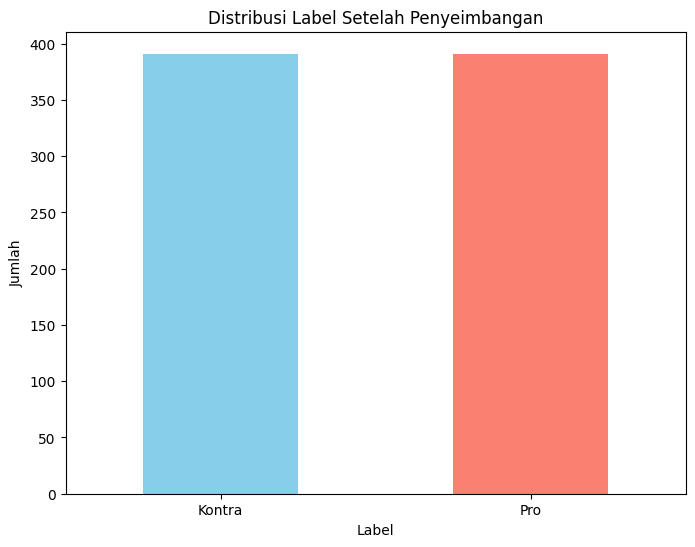

In [78]:
# Plot distribusi label setelah penyeimbangan
plt.figure(figsize=(8, 6))
balanced_data['Label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribusi Label Setelah Penyeimbangan')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [79]:
import os

# Path untuk menyimpan file
output_path = "C:/Users/Lenovo/Documents/RIDHO'S LIFE/Dodoo/KULIAH/Semester 5/Text Mining/AOL/balanced_data.xlsx"

# Simpan file ke path tersebut
balanced_data.to_excel(output_path, index=False)

print(f"File berhasil disimpan di: {output_path}")


File berhasil disimpan di: C:/Users/Lenovo/Documents/RIDHO'S LIFE/Dodoo/KULIAH/Semester 5/Text Mining/AOL/balanced_data.xlsx


In [16]:
data = pd.read_excel('balanced_data.xlsx')

In [17]:
data['Comment_Length'] = data['Comment'].apply(len)
data['Cleaned_Comment_Length'] = data['Cleaned_Comment'].apply(len)



In [18]:
# Statistik deskriptif untuk panjang komentar
print("Statistik Panjang Komentar (Original):\n", data['Comment_Length'].describe())
print("Statistik Panjang Komentar (Cleaned):\n", data['Cleaned_Comment_Length'].describe())

Statistik Panjang Komentar (Original):
 count     782.000000
mean      176.029412
std       227.417130
min         6.000000
25%        59.000000
50%       118.000000
75%       203.000000
max      3033.000000
Name: Comment_Length, dtype: float64
Statistik Panjang Komentar (Cleaned):
 count     782.000000
mean      100.556266
std       118.948859
min         5.000000
25%        37.000000
50%        69.000000
75%       120.750000
max      1600.000000
Name: Cleaned_Comment_Length, dtype: float64


In [19]:
from collections import Counter

In [20]:
# Tokenisasi komentar yang telah dibersihkan
tokenized_words = ' '.join(data['Cleaned_Comment']).split()
word_counts = Counter(tokenized_words)

In [21]:
# Kata yang paling umum
most_common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
print("Kata yang Paling Umum:\n", common_words_df)

Kata yang Paling Umum:
          Word  Frequency
0     merdeka        335
1          yg        329
2        ajar        305
3   kurikulum        305
4        guru        264
5       didik        226
6        anak        223
7     sekolah        139
8     program        126
9     menteri        102
10      siswa         95
11        tri         91
12  indonesia         82
13      ganti         75
14      hapus         72
15     nadiem         70
16        mas         64
17        nya         63
18        tdk         59
19       moga         58


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22116\3660518028.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')


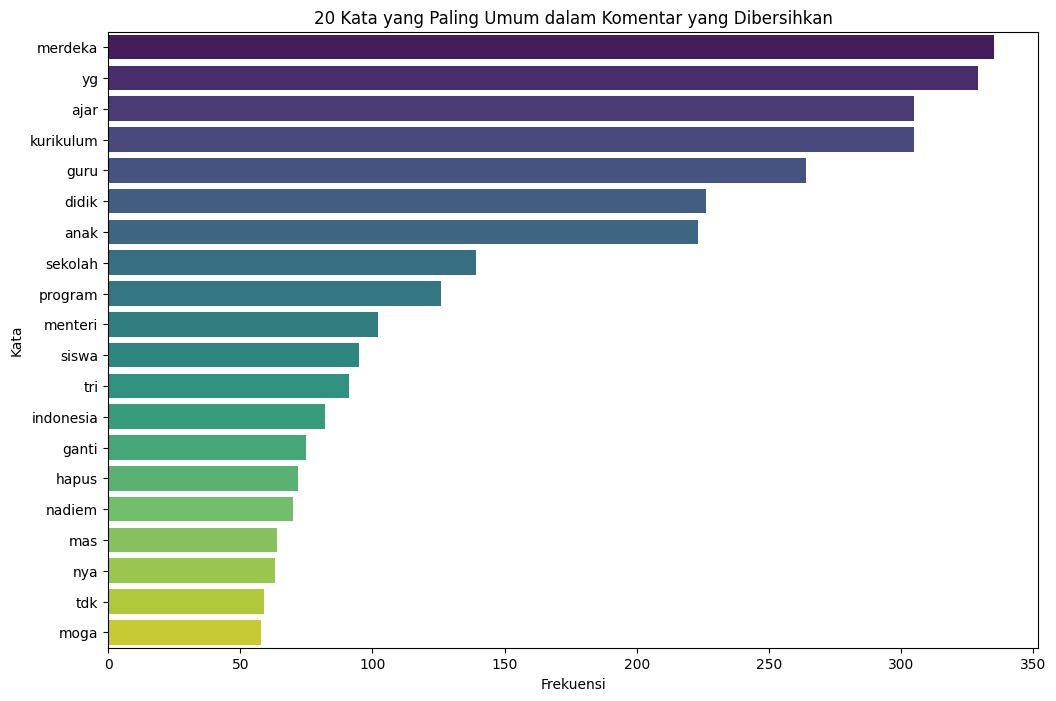

In [22]:
# Plot kata yang paling umum
plt.figure(figsize=(12, 8))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')
plt.title('20 Kata yang Paling Umum dalam Komentar yang Dibersihkan')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

### Data Split

In [23]:
from sklearn.model_selection import train_test_split
# Split data menjadi training dan testing
X = data['Cleaned_Comment']
y = data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
print("Jumlah data training:", len(X_train))
print("Jumlah data testing:", len(X_test))

Jumlah data training: 625
Jumlah data testing: 157


### Feature Engineering/Embedding

In [25]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from transformers import BertTokenizer, BertModel
import torch

c:\Users\Lenovo\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1. Doc2Vec
Alasan menggunakan Doc2Vec :
- Efisien pada Dataset Sedang hingga Kecil: Doc2Vec bekerja baik pada dataset yang tidak terlalu besar.
Representasi dokumen langsung diperoleh sebagai vektor, memudahkan integrasi dengan model machine learning sederhana.
- Relatif Cepat:
Doc2Vec lebih ringan dibandingkan model BERT, sehingga cocok untuk proyek dengan keterbatasan waktu atau sumber daya komputasi.
- Customizable: Kita dapat menyesuaikan parameter seperti ukuran vektor, metode pelatihan (Distributed Memory atau Distributed Bag of Words), dll.
- Cocok untuk Teks Pendek: Komentar pengguna biasanya pendek, sehingga Doc2Vec dapat menangkap pola dengan baik.


In [26]:
documents = [TaggedDocument(words=text.split(), 
                            tags=[i]) for i, text in enumerate(X_train)]


In [27]:
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5,
                        min_count=2, workers=4, epochs=40)


In [28]:
X_train_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_train]
X_test_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_test]


#### Modelling

##### 1.1.1 Baseline (Logistic Regression )

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [30]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_doc2vec, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [31]:
# Prediksi pada data test
y_pred_doc2vec = lr_model.predict(X_test_doc2vec)

In [32]:
print("Accuracy (Doc2Vec + Logistic Regression):", accuracy_score(y_test, y_pred_doc2vec))
print("Classification Report (Doc2Vec):\n", classification_report(y_test, y_pred_doc2vec))


Accuracy (Doc2Vec + Logistic Regression): 0.8089171974522293
Classification Report (Doc2Vec):
               precision    recall  f1-score   support

      Kontra       0.79      0.85      0.82        79
         Pro       0.83      0.77      0.80        78

    accuracy                           0.81       157
   macro avg       0.81      0.81      0.81       157
weighted avg       0.81      0.81      0.81       157



##### 1.1.2 Tuning Hyper Parameter Baseline 

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


In [34]:
lr_model = LogisticRegression(random_state=42)

In [35]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Jenis regularisasi
    'C': [0.01, 0.1, 1, 10, 100],                 # Invers dari kekuatan regularisasi
    'solver': ['liblinear', 'saga'],              # Solver untuk optimasi
    'max_iter': [100, 500, 1000]                  # Jumlah iterasi maksimum
}


In [36]:
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_doc2vec, y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\Lenovo\env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\env\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Lenovo\env\Lib\site-packages\sklearn\linear_model\_logistic.py", line 6

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [37]:
# Menampilkan hasil terbaik
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.7984


In [38]:
# Evaluasi pada data test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_doc2vec)

# Evaluasi performa
print("Accuracy (Test):", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy (Test): 0.8343949044585988
Classification Report:
               precision    recall  f1-score   support

      Kontra       0.81      0.87      0.84        79
         Pro       0.86      0.79      0.83        78

    accuracy                           0.83       157
   macro avg       0.84      0.83      0.83       157
weighted avg       0.84      0.83      0.83       157



##### 1.2.1 SVM

In [39]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [40]:
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_doc2vec, y_train)


SVC(C=1, kernel='linear', random_state=42)

In [41]:
y_pred_svm = svm_model.predict(X_test_doc2vec)

In [42]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy (Doc2Vec + SVM):", accuracy)
print("Classification Report (Doc2Vec + SVM):\n", classification_report(y_test, y_pred_svm))


Accuracy (Doc2Vec + SVM): 0.821656050955414
Classification Report (Doc2Vec + SVM):
               precision    recall  f1-score   support

      Kontra       0.78      0.90      0.84        79
         Pro       0.88      0.74      0.81        78

    accuracy                           0.82       157
   macro avg       0.83      0.82      0.82       157
weighted avg       0.83      0.82      0.82       157



##### 1.2.2 Hyperparameter Tuning SVM

In [43]:
# Definisikan parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Parameter regularisasi
    'kernel': ['linear', 'rbf', 'poly'],  # Jenis kernel
    'gamma': ['scale', 'auto'],  # Parameter kernel untuk rbf/poly
}

In [44]:
# GridSearchCV untuk hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_doc2vec, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVC(C=1, kernel='linear', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)

In [45]:
# Menampilkan hasil terbaik
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Score: 0.8016


In [46]:
# Menggunakan model terbaik untuk prediksi pada data testing
best_svm_model = grid_search.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_doc2vec)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy (Doc2Vec + SVM):", accuracy)
print("Classification Report (Doc2Vec + SVM):\n", classification_report(y_test, y_pred_svm))


Accuracy (Doc2Vec + SVM): 0.8471337579617835
Classification Report (Doc2Vec + SVM):
               precision    recall  f1-score   support

      Kontra       0.82      0.90      0.86        79
         Pro       0.89      0.79      0.84        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157



##### 1.3.1 Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [48]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)


In [49]:
rf_model.fit(X_train_doc2vec, y_train)
y_pred_rf = rf_model.predict(X_test_doc2vec)


In [50]:
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy (Doc2Vec + Random Forest):", accuracy)
print("Classification Report (Doc2Vec + Random Forest):\n", classification_report(y_test, y_pred_rf))


Accuracy (Doc2Vec + Random Forest): 0.8343949044585988
Classification Report (Doc2Vec + Random Forest):
               precision    recall  f1-score   support

      Kontra       0.81      0.87      0.84        79
         Pro       0.86      0.79      0.83        78

    accuracy                           0.83       157
   macro avg       0.84      0.83      0.83       157
weighted avg       0.84      0.83      0.83       157



##### 1.3.2 Hyperparameter Tuning Ramdom Forest

In [51]:
param_grid = {
    'n_estimators': [50, 100, 200],  # Jumlah pohon keputusan
    'max_depth': [None, 10, 20, 30],  # Kedalaman maksimum setiap pohon
    'min_samples_split': [2, 5, 10],  # Jumlah minimum sampel untuk split
    'min_samples_leaf': [1, 2, 4],    # Jumlah minimum sampel per daun
    'bootstrap': [True, False]        # Apakah bootstrap digunakan
}

In [52]:
# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(random_state=42)

In [53]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_doc2vec, y_train)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [54]:
# Menampilkan hasil terbaik
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Best Cross-Validation Score: 0.7984


In [55]:
# Menggunakan model terbaik untuk prediksi pada data testing
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_doc2vec)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy (Doc2Vec + Random Forest):", accuracy)
print("Classification Report (Doc2Vec + Random Forest):\n", classification_report(y_test, y_pred_rf))


Accuracy (Doc2Vec + Random Forest): 0.8471337579617835
Classification Report (Doc2Vec + Random Forest):
               precision    recall  f1-score   support

      Kontra       0.82      0.89      0.85        79
         Pro       0.88      0.81      0.84        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157



##### 1.4.1 XGBoost
XGBoost membutuhkan target y dalam format numerik (contoh: 0 untuk Kontra dan 1 untuk Pro), tetapi target y Anda saat ini masih berupa string (Kontra dan Pro). sehingga kita akan mengulang copy data balance data dan melakukan doc2vec ulang 

In [1]:
from xgboost import XGBClassifier

In [57]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [58]:
xgboost_data = data.copy()
xgboost_data['Label'] = xgboost_data['Label'].map({'Kontra': 0, 'Pro': 1})

In [59]:
# Split data menjadi training dan testing untuk XGBoost
X = xgboost_data['Cleaned_Comment']
y = xgboost_data['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [60]:
# Tokenisasi data untuk Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
# Melatih model Doc2Vec
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)


In [61]:
# Representasi Doc2Vec untuk training dan testing
X_train_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_train]
X_test_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_test]


In [3]:
# Inisialisasi model XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,)


In [63]:
# Melatih model XGBoost dengan data training
xgb_model.fit(X_train_doc2vec, y_train)
# Prediksi pada data testing
y_pred_xgb = xgb_model.predict(X_test_doc2vec)
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy (Doc2Vec + XGBoost):", accuracy)
print("Classification Report (Doc2Vec + XGBoost):\n", classification_report(y_test, y_pred_xgb))

Accuracy (Doc2Vec + XGBoost): 0.8089171974522293
Classification Report (Doc2Vec + XGBoost):
               precision    recall  f1-score   support

           0       0.80      0.84      0.81        79
           1       0.82      0.78      0.80        78

    accuracy                           0.81       157
   macro avg       0.81      0.81      0.81       157
weighted avg       0.81      0.81      0.81       157



##### 1.4.2 Hyperparameter Tuning XGBoost 

In [64]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [65]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [66]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [ ]:
grid_search.fit(X_train_doc2vec, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     m...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [72]:
# Menampilkan hasil terbaik
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Score: 0.8112


In [73]:
# Menggunakan model terbaik untuk prediksi pada data testing
best_xgb_model = grid_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_doc2vec)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy (Doc2Vec + XGBoost):", accuracy)
print("Classification Report (Doc2Vec + XGBoost):\n", classification_report(y_test, y_pred_xgb))


Accuracy (Doc2Vec + XGBoost): 0.8407643312101911
Classification Report (Doc2Vec + XGBoost):
               precision    recall  f1-score   support

           0       0.82      0.87      0.85        79
           1       0.86      0.81      0.83        78

    accuracy                           0.84       157
   macro avg       0.84      0.84      0.84       157
weighted avg       0.84      0.84      0.84       157



#### 2. BERT
Alasan menggunakan BERT:
- Pemahaman Konteks yang Mendalam: BERT memahami konteks kata secara dua arah (bidirectional), yang berarti sangat cocok untuk teks opini seperti komentar.
Misalnya, BERT dapat membedakan makna "kurikulum ini tidak buruk" dari "kurikulum ini buruk".
- Sangat Akurat: BERT umumnya memberikan performa yang lebih baik pada tugas klasifikasi teks dibandingkan metode tradisional seperti Doc2Vec.
- Transfer Learning: Kita dapat menggunakan model BERT yang sudah dilatih (pre-trained) dan menyesuaikannya (fine-tuning) pada dataset Kita. Ini membantu menghemat waktu dan tenaga untuk pelatihan model.


In [75]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [78]:
data

,no,Comment,Label,Cleaned_Comment,Comment_Length,Cleaned_Comment_Length
0,506,Betul.... kebanyakan kerja kelompok dan ngelua...,Kontra,banyak kerja kelompok ngeluarin byk uang murid...,129,70
1,335,Anak2 SD sekarang banyak yg tidak hapal perkal...,Kontra,anak sd yg hapal kali,61,21
2,1203,Mendukung merdeka belajar !,Pro,dukung merdeka ajar,27,19
3,1287,Saya baru saja mengikuti salah satu program PM...,Pro,ikut salah program pmm syukur bangga ikut i lo...,148,81
4,1169,Menyimak 4 pokok kebijakan mas Menteri. Semoga...,Pro,simak pokok bijak mas menteri moga sosialisasi...,126,82
...,...,...,...,...,...,...
777,1056,Kelebihan kurikulum merdeka yaitu kemerdekaan ...,Pro,lebih kurikulum merdeka merdeka guru kurang be...,153,107
778,1101,Masya Allah... Kebijakan kurikulum merdeka yan...,Pro,masya allah bijak kurikulum merdeka moga wujud...,172,95
779,1265,Goodluck,Pro,goodluck,8,8
780,152,dan murid semakin merdeka untuk malas belajar ...,Kontra,murid merdeka malas ajar pergi kantin main game,76,47


In [76]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [70]:
data['Label'] = data['Label'].map({'Kontra': 0, 'Pro': 1})

In [71]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['Cleaned_Comment'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
)


In [79]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')


In [80]:
# Dataset dan DataLoader
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_length=128)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

##### 2.1 Modeling IndoBERT

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [82]:
# Load pre-trained IndoBERT with classification head
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=2)
model = model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)
# Loss Function
loss_fn = torch.nn.CrossEntropyLoss()


In [90]:
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


Epoch 1/3, Loss: 0.02969232316245325
Epoch 2/3, Loss: 0.055460152767045655
Epoch 3/3, Loss: 0.028164640851900912


In [91]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [92]:
accuracy = accuracy_score(all_labels, all_preds)
print("Accuracy (IndoBERT):", accuracy)
print("Classification Report:\n", classification_report(all_labels, all_preds))


Accuracy (IndoBERT): 0.8343949044585988
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        79
           1       0.82      0.85      0.84        78

    accuracy                           0.83       157
   macro avg       0.83      0.83      0.83       157
weighted avg       0.83      0.83      0.83       157



##### 2.1.2 Hyperparameter Tuning Indobert

In [94]:
hyperparameter_space = {
    'learning_rate': [2e-5, 3e-5, 5e-5],
    'batch_size': [16, 32],
    'epochs': [2, 3, 4]
}


In [93]:
best_accuracy = 0
best_params = {}

In [95]:
for lr in hyperparameter_space['learning_rate']:
    for batch_size in hyperparameter_space['batch_size']:
        for epochs in hyperparameter_space['epochs']:
            print(f"Testing with lr={lr}, batch_size={batch_size}, epochs={epochs}")

            # Buat DataLoader baru dengan batch size yang berbeda
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)

            # Load model IndoBERT
            model = BertForSequenceClassification.from_pretrained(
                'indobenchmark/indobert-base-p2',
                num_labels=2
            )
            model = model.to(device)

            # Optimizer
            optimizer = AdamW(model.parameters(), lr=lr)

            # Loss Function
            loss_fn = torch.nn.CrossEntropyLoss()

            # Training
            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for batch in train_loader:
                    optimizer.zero_grad()
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")


Testing with lr=2e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Lenovo\env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/2, Loss: 0.5093717344105244
Epoch 2/2, Loss: 0.24897656282410024
Testing with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.5573879294097424
Epoch 2/3, Loss: 0.2468533182516694
Epoch 3/3, Loss: 0.08163820721674711
Testing with lr=2e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5219862002879381
Epoch 2/4, Loss: 0.27389766462147236
Epoch 3/4, Loss: 0.16381229662802071
Epoch 4/4, Loss: 0.05144074271665886
Testing with lr=2e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.5542582109570503
Epoch 2/2, Loss: 0.2843752712011337
Testing with lr=2e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.5760920763015747
Epoch 2/3, Loss: 0.3070092909038067
Epoch 3/3, Loss: 0.14997496912255884
Testing with lr=2e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5457675084471703
Epoch 2/4, Loss: 0.3118745654821396
Epoch 3/4, Loss: 0.1877175599336624
Epoch 4/4, Loss: 0.07128717373125255
Testing with lr=3e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.517913764808327
Epoch 2/2, Loss: 0.2310643338598311
Testing with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.4998307652771473
Epoch 2/3, Loss: 0.25566638763993976
Epoch 3/3, Loss: 0.17936633339850233
Testing with lr=3e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5241314485669136
Epoch 2/4, Loss: 0.2727113240864128
Epoch 3/4, Loss: 0.1091043281601742
Epoch 4/4, Loss: 0.045052002498414366
Testing with lr=3e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.5124127373099328
Epoch 2/2, Loss: 0.2313323225826025
Testing with lr=3e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.5360196202993393
Epoch 2/3, Loss: 0.2283964853733778
Epoch 3/3, Loss: 0.10340985022485256
Testing with lr=3e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5902820006012917
Epoch 2/4, Loss: 0.28674570843577385
Epoch 3/4, Loss: 0.13417042279615998
Epoch 4/4, Loss: 0.05216868931893259
Testing with lr=5e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.6400703243911267
Epoch 2/2, Loss: 0.4197372902184725
Testing with lr=5e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.511025695875287
Epoch 2/3, Loss: 0.25683445371687413
Epoch 3/3, Loss: 0.09571913913823664
Testing with lr=5e-05, batch_size=16, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5345123574137688
Epoch 2/4, Loss: 0.31323414025828245
Epoch 3/4, Loss: 0.15211928831413388
Epoch 4/4, Loss: 0.07997675954829901
Testing with lr=5e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2, Loss: 0.6017230436205864
Epoch 2/2, Loss: 0.31844894140958785
Testing with lr=5e-05, batch_size=32, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 0.5803822770714759
Epoch 2/3, Loss: 0.2703511007130146
Epoch 3/3, Loss: 0.09926427435129881
Testing with lr=5e-05, batch_size=32, epochs=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4, Loss: 0.5665184080600738
Epoch 2/4, Loss: 0.28735905662178995
Epoch 3/4, Loss: 0.08528618169948458
Epoch 4/4, Loss: 0.06350248074159026


In [103]:
            # Evaluation
            model.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    preds = torch.argmax(logits, dim=1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            accuracy = accuracy_score(all_labels, all_preds)
            print(f"Accuracy for lr={lr}, batch_size={batch_size}, epochs={epochs}: {accuracy}")

            # Simpan hyperparameter terbaik
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'epochs': epochs
                }


Accuracy for lr=5e-05, batch_size=32, epochs=4: 0.8407643312101911


In [104]:
# ---- 3. Best Parameters ----
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)
print("Classification Report:\n", classification_report(all_labels, all_preds))


Best Hyperparameters: {'learning_rate': 5e-05, 'batch_size': 32, 'epochs': 4}
Best Accuracy: 0.8407643312101911
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.83        79
           1       0.81      0.88      0.85        78

    accuracy                           0.84       157
   macro avg       0.84      0.84      0.84       157
weighted avg       0.84      0.84      0.84       157



# Kesimpulan 

# Testing

In [105]:
new_comments = ["Kurikulum Merdeka sangat membantu!", "Ini hanya membebani siswa."]
new_tokens = tokenizer(new_comments, truncation=True, padding='max_length', max_length=128, return_tensors="pt")

# Prediksi menggunakan model terbaik (contoh IndoBERT)
model.eval()
with torch.no_grad():
    inputs = new_tokens['input_ids'].to(device)
    attention_mask = new_tokens['attention_mask'].to(device)
    outputs = model(inputs, attention_mask=attention_mask)
    predictions = torch.argmax(outputs.logits, dim=1)
print("Predictions:", predictions.cpu().numpy())  # 0 untuk Kontra, 1 untuk Pro


Predictions: [1 0]


# Evaluasi Confusion Matriks

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

In [97]:
# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kontra", "Pro"])
    disp.plot(cmap='Greens')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [83]:
# Load dataset
data = pd.read_excel('balanced_data.xlsx')
data['Label'] = data['Label'].map({'Kontra': 0, 'Pro': 1})  # Mapping label untuk 2 label


In [84]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    data['Cleaned_Comment'], data['Label'], test_size=0.2, random_state=42, stratify=data['Label']
)

# Proses Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(X_train)]
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4, epochs=40)

# Embedding data
X_train_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_train]
X_test_doc2vec = [doc2vec_model.infer_vector(text.split()) for text in X_test]


Logistic Regression:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84        79
           1       0.85      0.81      0.83        78

    accuracy                           0.83       157
   macro avg       0.84      0.83      0.83       157
weighted avg       0.84      0.83      0.83       157



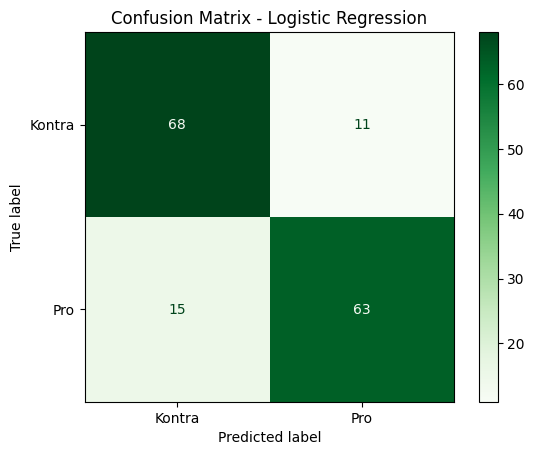

Random Forest:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        79
           1       0.86      0.79      0.83        78

    accuracy                           0.83       157
   macro avg       0.84      0.83      0.83       157
weighted avg       0.84      0.83      0.83       157



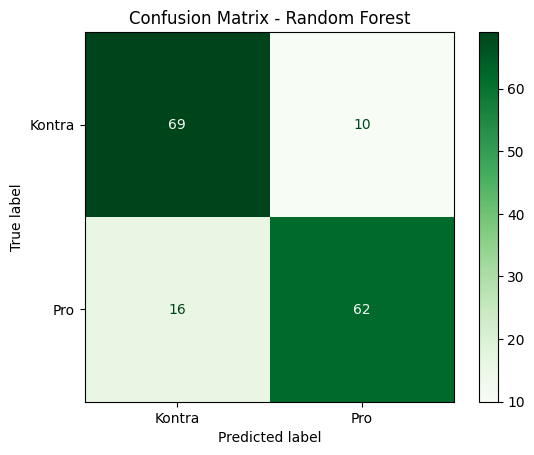

SVM:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85        79
           1       0.84      0.87      0.86        78

    accuracy                           0.85       157
   macro avg       0.85      0.85      0.85       157
weighted avg       0.85      0.85      0.85       157



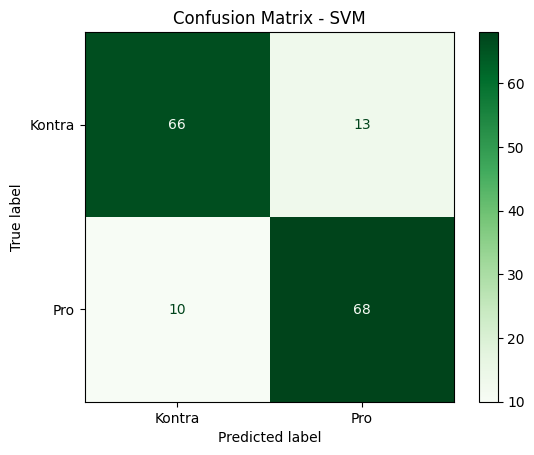

XGBoost:
               precision    recall  f1-score   support

           0       0.81      0.80      0.80        79
           1       0.80      0.81      0.80        78

    accuracy                           0.80       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.80      0.80      0.80       157



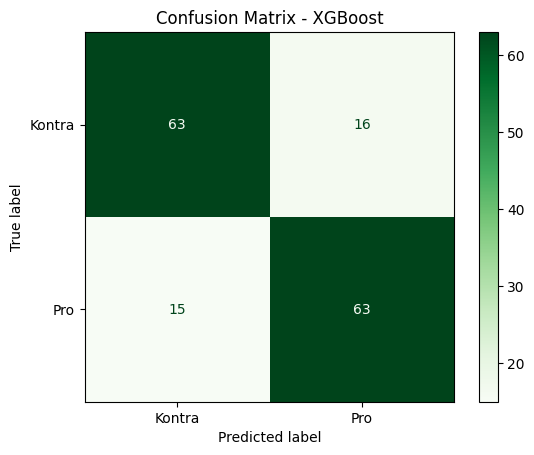

In [98]:
# Logistic Regression
logistic_model = LogisticRegression(C=10, max_iter=100, penalty='l1', solver='liblinear')
logistic_model.fit(X_train_doc2vec, y_train)
y_pred_logistic = logistic_model.predict(X_test_doc2vec)
print("Logistic Regression:\n", classification_report(y_test, y_pred_logistic))
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression")

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=50, max_depth=10, min_samples_leaf=2, min_samples_split=10, bootstrap=False
)
rf_model.fit(X_train_doc2vec, y_train)
y_pred_rf = rf_model.predict(X_test_doc2vec)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")

# SVM
svm_model = SVC(C=100, gamma='scale', kernel='linear')
svm_model.fit(X_train_doc2vec, y_train)
y_pred_svm = svm_model.predict(X_test_doc2vec)
print("SVM:\n", classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

# XGBoost
xgb_model = XGBClassifier(
    colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0
)
xgb_model.fit(X_train_doc2vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_doc2vec)
print("XGBoost:\n", classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")

In [86]:
# Dataset Class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [87]:
# Tokenizer
max_length = 128
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

# Dataset dan DataLoader
train_dataset = TextDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_length)
test_dataset = TextDataset(X_test.tolist(), y_test.tolist(), tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', num_labels=2)
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Lenovo\env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [88]:
# Training Loop
epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

Epoch 1/4, Loss: 0.5603860855102539
Epoch 2/4, Loss: 0.23608038984239102
Epoch 3/4, Loss: 0.19119498813524843
Epoch 4/4, Loss: 0.09081158954650163


In [89]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


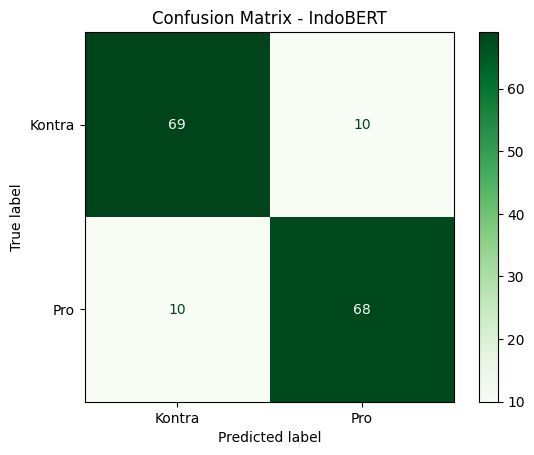

In [100]:
# Metrics
accuracy = accuracy_score(all_labels, all_preds)
plot_confusion_matrix(all_labels, all_preds, "IndoBERT")


# Kata-Kata Paling Berpengaruh

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
data = pd.read_excel('balanced_data.xlsx')

In [115]:
X = data['Cleaned_Comment']
y = data['Label'].map({'Kontra': 0, 'Pro': 1})  # Konversi label ke numerik


In [117]:
vectorizer = CountVectorizer(max_features=1000, stop_words='english')  # Maksimal 1000 fitur
X_vectorized = vectorizer.fit_transform(X)


In [118]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_vectorized, y)


RandomForestClassifier(n_estimators=200, random_state=42)

In [119]:
# Mendapatkan feature importance
importances = rf_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()

important_words_rf = pd.DataFrame({
    'Word': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [120]:
# Menampilkan 20 kata paling penting
top_rf_words = important_words_rf.head(20)

print("Top 20 Words Based on Feature Importance (Random Forest):")
print(top_rf_words)

Top 20 Words Based on Feature Importance (Random Forest):
          Word  Importance
763    program    0.023916
459  kurikulum    0.023167
541        mas    0.022886
231      ganti    0.021212
261      hapus    0.020330
45        anak    0.018507
356     kampus    0.016264
562    merdeka    0.015933
517  mahasiswa    0.014990
586       moga    0.012637
250       guru    0.011939
19        ajar    0.011392
384    kembali    0.010891
995         yg    0.010837
84      bangga    0.010180
999     zonasi    0.009543
184      didik    0.009416
537     mantap    0.009410
398      keren    0.009257
478     lanjut    0.009188


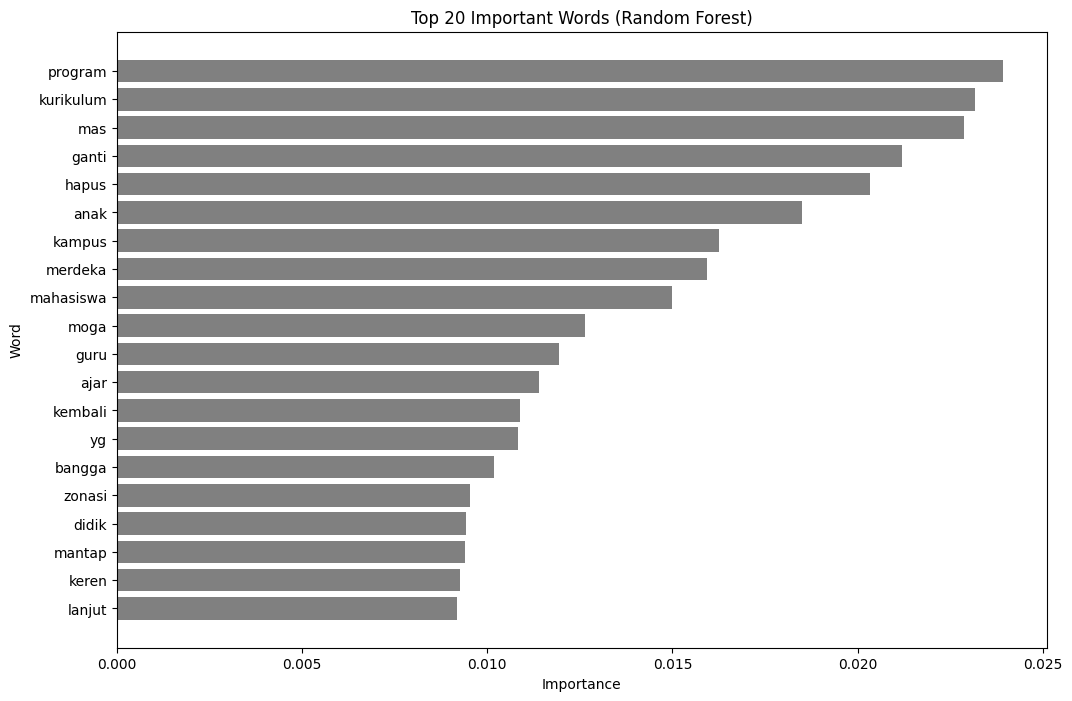

In [124]:
# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_rf_words['Word'], top_rf_words['Importance'], color='gray')
plt.title('Top 20 Important Words (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Word')
plt.gca().invert_yaxis()
plt.show()